In [1]:
# Solve Burgers eq:  u_t + u*u_x -0.001 u_xx = 0
# u(x,t)
# BC         : u(x,0) = sin(x)
# IC         : u(-1,t) = i(1,t) = 0 

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

In [2]:
def boundery(x):
    return [np.sin(x)]      

def construct_training_set_BC(dx):
    x = np.pi*np.arange(-1, 1.1 , 0.1, dtype = np.float32)
    zeros = np.zeros(np.shape(x))
    y_train_BC = np.array(boundery(x))[0]
    x_train_BC = np.vstack((x, zeros)).T
    #print ('x_train_BC type = ',type(x_train_BC))
    #print ('y_train_BC type = ',type(y_train_BC))
    print ('x_train_BC = ',x_train_BC)
    print ('y_train_BC = ',y_train_BC)
    return x_train_BC,y_train_BC

def construct_training_set_IC(dt):
    t =  (np.arange(0, 1.0001 , dt, dtype = np.float32))
    Nt = np.shape(t)
    x1 = np.ones(Nt)
    xminus1 = x1-2.0
    x1_t = np.vstack((x1, t)).T.tolist()
    x_minus1_t = np.vstack((xminus1, t)).T.tolist()
    x_train_IC = np.array( x_minus1_t+x1_t)
    y_train_IC = np.zeros(np.shape(x_train_IC)[0])
    #print ('x_train_IC = ',x_train_IC)
    #print ('y_train_IC = ',y_train_IC)
    #print (np.shape(x_train_IC)[0])
    return x_train_IC,y_train_IC


def construct_training_set_sampled(N_points):
    xt = []
    for i in range(0, N_points):
      xt.append([np.random.uniform(-np.pi,np.pi),np.random.uniform(0,1)])
    xt = np.array(xt)
    y_IC = np.zeros(N_points)
    #print (xt)
    return xt,y_IC

def construct_training_set(dx,dt,N_points):
    x_train_BC, y_train_BC = construct_training_set_BC(dx)
    x_train_IC, y_train_IC = construct_training_set_IC(dt)    
    x_train_S,  y_train_S  = construct_training_set_sampled(N_points)
    x_train =  np.array(x_train_BC.tolist() + x_train_IC.tolist())
    y_train =  np.array(y_train_BC.tolist() + y_train_IC.tolist())
    #x_train[0][0]=1 # just for checking hessian calculation with fixed NN weihgts
    #x_train[0][1]=2
    #print ('x_train = ',x_train)    
    #print ('y_train = ',y_train)
    #print ('x_train_S = ',)
    return x_train,y_train, x_train_S,  y_train_S

In [3]:
def init_model_improved():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(2,))) 
    
    # רשת רחבה ועמוקה יותר
    model.add(tf.keras.layers.Dense(20, activation='swish', kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(20, activation='swish', kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(20, activation='swish', kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(20, activation='swish', kernel_initializer='glorot_normal'))
    
    # שכבת יציאה
    model.add(tf.keras.layers.Dense(1))
    return model


def init_model1(num_hidden_layers=1, num_neurons_per_layer=2):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(2,))) 
    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,activation=tf.keras.activations.exponential,kernel_initializer='glorot_normal'))
    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    #print (model.get_layer(index=1))
    return model

def init_model2():
    inputs = Input(shape=(2,))
    x = Dense(16, 'tanh')(inputs)
    x = Dense(8, 'tanh')(x)
    x = Dense(4)(x)
    y = Dense(1)(x)
    model = Model(inputs=inputs, outputs=y)
    return model

def set_weights_for_specific_model_layer(model):
    layer_weights_shape = [w.shape for w in model.get_weights()]
    #print(f"layers weight shapes: {layer_weights_shape}")
    custom_kernel = np.ones(layer_weights_shape[0]) 
    custom_bias = np.zeros(layer_weights_shape[1])
    model.set_weights([custom_kernel, custom_bias]) 
    
def set_weights_as_one_for_model(model):
    current_weights = model.get_weights()
    new_weights = [np.ones_like(w) for w in current_weights]
    model.set_weights(new_weights)  
    
def set_internal_variables_for_model(model,m,b):
    tm = tf.convert_to_tensor(m)
    tb = tf.convert_to_tensor(b)
    first_layer  = model.layers[0]
    secend_layer = model.layers[1]
    set_weights_for_specific_model_layer(first_layer)
    set_weights_for_specific_model_layer(secend_layer)
    dense_layer = model.get_layer(index=0)
    dense_layer.set_weights([tm,tb])
    #print (' network trainable_variables  = ')
    #print( model.trainable_variables)
    #print ('')
    #print (' W1  = ')
    #print( model.trainable_variables[0].numpy())
    #print (' b1 = ')
    #print( model.trainable_variables[1].numpy())
    #print (' W2 = ')
    #print( model.trainable_variables[2].numpy())
    #print (' b2 = ')
    #print( model.trainable_variables[3].numpy())

def excat_solution(model,r):
    w11=model.trainable_variables[0][0][0].numpy()
    w12=model.trainable_variables[0][0][1].numpy()
    w21=model.trainable_variables[0][1][0].numpy()
    w22=model.trainable_variables[0][1][1].numpy()
    w13=model.trainable_variables[2][0].numpy()
    w23=model.trainable_variables[2][1].numpy()
    x = r.numpy()[0][0]
    y = r.numpy()[0][1]
    # print ('w11 w12 = ',w11,w12)
    # print ('w21,w22 = ',w21,w22)    
    # print ('w13,w23 = ',w13,w23)
    # print ('x, y = ',x,y)
    du_dx_dx = w13*w11**2*np.exp(w11*x + w21*y) + w23*w12**2*np.exp(w12*x + w22*y) 
    du_dy_dy = w13*w21**2*np.exp(w11*x + w21*y) + w23*w22**2*np.exp(w12*x + w22*y)    
    print ('exact du_dx_dx, du_dy_dy = ',du_dx_dx,du_dy_dy)
    return (du_dx_dx,du_dy_dy)


In [4]:
def one_epoch_fully_batched_AI(model, opt, x_train, y_train, dataset_S, epoch_nnumber):    
    with tf.GradientTape() as model_tape:  
        # חישוב ה-Loss על ה-Data
        prediction = model(x_train)
        l1 = loss_fn(y_train, prediction) # כעת שניהם float32
        
        l2_accumulated = 0.0
        
        for step, (x, y_true) in enumerate(dataset_S):
            x_variable = tf.Variable(x) # x הוא float32 כעת
            
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_variable) 
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(x_variable)
                    u = model(x_variable) # u הוא float32
                
                grad_u = tape1.gradient(u, x_variable) # גם הנגזרת תהיה float32
            
            hessian_u = tape2.jacobian(grad_u, x_variable)    
            
            # שליפת הערכים (כולם float32)
            ux = grad_u[0][0]
            ut = grad_u[0][1]
            uxx = hessian_u[0][0][0][0]
            u_val = u[0][0] # גישה לערך הסקלרי
            
            # חישוב ה-Residual (הכל float32, אין שגיאת Mul)
            l2_local = tf.abs(ut + u_val * ux - (0.001) * uxx)
            
            l2_accumulated += l2_local
        
        # ממוצע
        l2 = l2_accumulated / (step + 1)
        
        # סכום סופי
        loss = l1 + l2

    grad = model_tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grad, model.trainable_variables))
    
    print(f"epoch {epoch_nnumber}: l1 = {l1.numpy():.5f} l2 = {l2.numpy():.5f} loss={loss.numpy():.5f}")

In [5]:
def one_epoch_fully_batched(model,opt,x_train, y_train,dataset_S,epoch_nnumber):    
    with tf.GradientTape() as model_tape:  
        l1_temp = loss_fn(y_train,model(x_train))   
        l1 = tf.cast(l1_temp, dtype=tf.float64)
        for step, (x,y_true) in enumerate(dataset_S):
            x_variable = tf.Variable(x) 
            with tf.GradientTape(persistent=True) as loss_tape2:
                loss_tape2.watch(x_variable) 
                with tf.GradientTape(persistent=True) as loss_tape1:
                    loss_tape1.watch(x_variable)
                    u = model(x_variable)
                    grad_u = loss_tape1.gradient(u,x_variable)        
                hessian_u = loss_tape2.jacobian(grad_u, x_variable)    
                ux = grad_u[0][0]
                ut = grad_u[0][1]
                uxx = hessian_u[0][0][0][0]
                u_val = u[0][0] # גישה לערך הסקלר
                #u  = u.numpy()          
                
                
                l2_abs = tf.abs(ut + u*ux - (0.001)*uxx)
                if step==0:
                    l2 = l2_abs
                else:         
                    l2 = l2 + l2_abs
                #print (step, l2)
        loss = tf.math.reduce_mean(l1+l2)
        grad = model_tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))
        #print ('l1 = ',l1)
        #print ('l2 = ',l2)
        print(f"epoch_nnumber {epoch_nnumber}: l1 = {l1} l2 = {l2} loss={loss.numpy()}")
    

In [6]:
@tf.function  # מאיץ את הריצה על ידי קימפול לגרף סטטי
def train_step_vectorized(model, x_collocation, x_data, y_data):
    """
    x_collocation: נקודות ה-PDE (בתוך התחום) - Batch מלא
    x_data: נקודות שפה והתחלה (BC + IC) - Batch מלא
    y_data: הערכים האמיתיים בשפה/התחלה
    """
    with tf.GradientTape() as tape:
        # === 1. חישוב Loss פיזיקלי (PDE) על כל ה-Batch במקביל ===
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x_collocation)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(x_collocation)
                u = model(x_collocation) # חישוב u לכל הנקודות יחד (N, 1)
            
            # נגזרת ראשונה: מחשב את (du/dx, du/dt) לכל נקודה במטריצה
            # TensorFlow יודע לעשות זאת אלמנט-אלמנט אוטומטית
            grads = tape1.gradient(u, x_collocation) 
            u_x = grads[:, 0:1] # העמודה הראשונה היא הנגזרת לפי x
            u_t = grads[:, 1:2] # העמודה השנייה היא הנגזרת לפי t
            
        # נגזרת שניה: גוזרים את u_x שוב לפי הקלט
        grad_u_x = tape2.gradient(u_x, x_collocation)
        u_xx = grad_u_x[:, 0:1] # הנגזרת של u_x לפי x
        
        del tape1 # שחרור זיכרון
        del tape2
        
        # חישוב השגיאה (Residual) לכל ה-Batch בפעולה וקטורית
        # u, u_x, u_t, u_xx הם כולם טנזורים בגודל (N, 1)
        f = u_t + u * u_x - (0.001) * u_xx
        mse_pde = tf.reduce_mean(tf.square(f))
        
        # === 2. חישוב Loss על הדאטה (תנאי שפה/התחלה) ===
        u_pred_data = model(x_data)
        mse_data = tf.reduce_mean(tf.square(y_data - u_pred_data))
        lambda_data = 100000.0
        # סכום ה-Loss
        total_loss = lambda_data * mse_data + mse_pde

    # עדכון המשקולות
    grads_weights = tape.gradient(total_loss, model.trainable_variables)
    opt.apply_gradients(zip(grads_weights, model.trainable_variables))
    
    return total_loss, mse_data, mse_pde

In [7]:
# === פונקציית אימון גמישה ===
@tf.function
def train_step_flexible(model, x_col, x_data, y_data, use_pde):
    with tf.GradientTape() as tape:
        # 1. חישוב Loss על הדאטה (תמיד קיים)
        u_pred_data = model(x_data)
        mse_data = tf.reduce_mean(tf.square(y_data - u_pred_data))
        
        mse_pde = tf.constant(0.0)
        
        # 2. חישוב Loss פיזיקלי (רק אם use_pde=True)
        if use_pde:
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_col)
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(x_col)
                    u = model(x_col)
                
                grads = tape1.gradient(u, x_col)
                u_x = grads[:, 0:1]
                u_t = grads[:, 1:2]
            
            grad_u_x = tape2.gradient(u_x, x_col)
            u_xx = grad_u_x[:, 0:1]
            
            del tape1, tape2
            
            # משוואת בורגרס
            f = u_t + u * u_x - (0.001) * u_xx
            mse_pde = tf.reduce_mean(tf.square(f))
        
        # חישוב Loss כולל
        # בשלב הראשון mse_pde הוא 0, אז הרשת לומדת רק דאטה
        loss = mse_data + mse_pde 

    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss, mse_data, mse_pde

In [8]:
N_points=3000
#sample_number = 4
N_epochs=30
loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size',name='mean_squared_error')
x_train, y_train,x_train_S,  y_train_S = construct_training_set(0.1,0.1,N_points)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_train_S = tf.convert_to_tensor(x_train_S, dtype=tf.float32) # זה קריטי!
y_train_S = tf.convert_to_tensor(y_train_S, dtype=tf.float32)

dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(1)
#dataset_S = tf.data.Dataset.from_tensor_slices((x_train_S,y_train_S)).batch(1)
# במקום batch(1), השתמש ב-batch בגודל כל הדאטה או מספר גדול אחר
batch_size = N_points  # או מספר גדול אחר כמו 1024
dataset_S = tf.data.Dataset.from_tensor_slices((x_train_S, y_train_S)).batch(batch_size)

model = init_model_improved()
#model = init_model2()
#model.summary()

x_train_BC =  [[-3.14159274e+00  0.00000000e+00]
 [-2.82743335e+00  0.00000000e+00]
 [-2.51327395e+00  0.00000000e+00]
 [-2.19911480e+00  0.00000000e+00]
 [-1.88495529e+00  0.00000000e+00]
 [-1.57079601e+00  0.00000000e+00]
 [-1.25663662e+00  0.00000000e+00]
 [-9.42477286e-01  0.00000000e+00]
 [-6.28317952e-01  0.00000000e+00]
 [-3.14158589e-01  0.00000000e+00]
 [ 7.49014077e-07  0.00000000e+00]
 [ 3.14160109e-01  0.00000000e+00]
 [ 6.28319442e-01  0.00000000e+00]
 [ 9.42478776e-01  0.00000000e+00]
 [ 1.25663817e+00  0.00000000e+00]
 [ 1.57079744e+00  0.00000000e+00]
 [ 1.88495684e+00  0.00000000e+00]
 [ 2.19911623e+00  0.00000000e+00]
 [ 2.51327562e+00  0.00000000e+00]
 [ 2.82743478e+00  0.00000000e+00]
 [ 3.14159417e+00  0.00000000e+00]]
y_train_BC =  [ 8.7422777e-08 -3.0901703e-01 -5.8778542e-01 -8.0901700e-01
 -9.5105660e-01 -1.0000000e+00 -9.5105636e-01 -8.0901670e-01
 -5.8778477e-01 -3.0901635e-01  7.4901408e-07  3.0901781e-01
  5.8778602e-01  8.0901760e-01  9.5105684e-01  1.0000

In [9]:
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)
# לולאת האימון הראשית
for epoch in range(N_epochs):
    # שליפת באצ'ים (אם הדאטה קטן, זה יהיה איטרציה אחת בלבד
    for x_col_batch, _ in dataset_S:
        loss, l_data, l_pde = train_step_vectorized(model, x_col_batch, x_train, y_train)
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss={loss:.5f}, Data={l_data:.5f}, PDE={l_pde:.5f}")

Epoch 0: Total Loss=23368.80664, Data=0.23369, PDE=0.00100
Epoch 10: Total Loss=23320.79102, Data=0.23321, PDE=0.00009
Epoch 20: Total Loss=23261.18555, Data=0.23261, PDE=0.00003


In [10]:
# === הגדרות לאימון ===
N_epochs_pretrain = 500  # אימון רק על הדאטה
N_epochs_physics = 1  # אימון מלא
lambda_data = 1.0        # בשלב השני אפשר להחזיר ל-1 כי הרשת כבר במקום טוב
# אופטימייזר
opt = tf.keras.optimizers.Adam(learning_rate=0.005) # קצב למידה קצת יותר נמוך ויצי

# === שלב 1: אימון מקדים (רק דאטה) ===
print("Starting Pre-training (Data only)...")
for epoch in range(N_epochs_pretrain):
    for x_col_batch, _ in dataset_S:
        loss, l_data, l_pde = train_step_flexible(model, x_col_batch, x_train, y_train, use_pde=False)
    
    if epoch % 50 == 0:
        print(f"Pre-train Epoch {epoch}: Data Loss={l_data.numpy():.5f}")

print("Pre-training done. Model should match IC/BC now.")

# === שלב 2: אימון מלא (פיזיקה + דאטה) ===
print("Starting Physics training...")
for epoch in range(N_epochs_physics):
    for x_col_batch, _ in dataset_S:
        loss, l_data, l_pde = train_step_flexible(model, x_col_batch, x_train, y_train, use_pde=True)
        
    if epoch % 100 == 0:
        print(f"Physics Epoch {epoch}: Total={loss:.5f}, Data={l_data:.5f}, PDE={l_pde:.5f}")

Starting Pre-training (Data only)...
Pre-train Epoch 0: Data Loss=0.23264
Pre-train Epoch 50: Data Loss=0.23256
Pre-train Epoch 100: Data Loss=0.23256
Pre-train Epoch 150: Data Loss=0.23256
Pre-train Epoch 200: Data Loss=0.23256
Pre-train Epoch 250: Data Loss=0.23256
Pre-train Epoch 300: Data Loss=0.23256
Pre-train Epoch 350: Data Loss=0.23256
Pre-train Epoch 400: Data Loss=0.23256
Pre-train Epoch 450: Data Loss=0.23256
Pre-training done. Model should match IC/BC now.
Starting Physics training...
Physics Epoch 0: Total=0.23256, Data=0.23256, PDE=0.00000


In [11]:
def visualize_solution(model):
    # 1. יצירת רשת נקודות (Grid) צפופה לבדיקה
    # אנו יוצרים 200 נקודות במרחב ו-100 בזמן
    x = np.linspace(-3.15, 3.15, 200)
    t = np.linspace(0, 1, 100)
    X, T = np.meshgrid(x, t) # X, T הם מטריצות דו-ממדיות
    
    # 2. שיטוח והכנת הקלט למודל
    # המודל מצפה לקלט בצורה (N, 2), אז אנו משטחים את המטריצות
    X_flat = X.flatten()[:, None]
    T_flat = T.flatten()[:, None]
    
    # איחוד לטנזור אחד של זוגות (x,t)
    input_data = np.hstack((X_flat, T_flat))
    input_data = tf.cast(input_data, dtype=tf.float32) # המרה קריטית ל-float32!
    
    # 3. ביצוע החיזוי
    u_pred = model(input_data)
    
    # 4. המרה חזרה לצורה דו-ממדית לציור
    U = u_pred.numpy().reshape(X.shape)
    
    # === גרף 1: מפת חום (Heatmap) ===
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # pcolormesh מצייר את מפת הצבעים
    mesh = plt.pcolormesh(X, T, U, cmap='jet', shading='auto')
    plt.colorbar(mesh, label='u(x,t)')
    plt.xlabel('x')
    plt.ylabel('t (Time)')
    plt.title('Burgers Equation Solution (Heatmap)')
    
    # === גרף 2: חתכים בזמן (Snapshots) ===
    plt.subplot(1, 2, 2)
    
    # חתך בזמן t=0 (תנאי התחלה)
    plt.plot(x, U[0, :], 'b--', linewidth=2, label='t = 0.0 (Prediction)')
    # חתך בזמן t=0.5
    plt.plot(x, U[50, :], 'g-', linewidth=2, label='t = 0.5')
    # חתך בזמן t=1.0 (סוף)
    plt.plot(x, U[-1, :], 'r-', linewidth=2, label='t = 1.0')
    
    # הוספת השוואה לתנאי ההתחלה האמיתי (רק לוודא שהרשת למדה אותו)
    plt.plot(x, -np.sin(np.pi*x), 'k:', alpha=0.5, label='Exact IC (Reference)')
    
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Wave Profile at Different Times')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


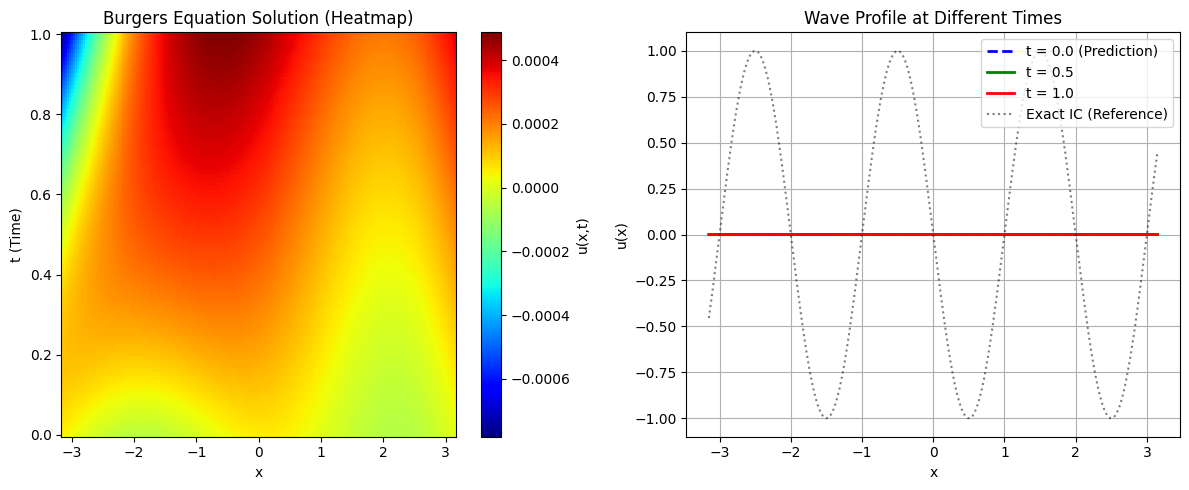

In [12]:
visualize_solution(model)


In [13]:
# u(x,t)
# Burgers eq.: u_t+uu_x-(0.001)u_xx = 0
# BC         : u(x,t = 0) = sin(x)
# IC         : u(x = -1,t) = i(x = 1,t) = 0 